# 1 Load Datasets and Libraries

1.1 Load Libraries


In [2]:
import numpy as np
import gc
import pandas as pd
import seaborn as sns
import sklearn.tree as tree
import sklearn.ensemble as ensem
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
import sklearn.metrics as metric
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')


1.2 Load Datasets


In [3]:
train_transaction = pd.read_csv('C:/Users/ar194371/Documents/Data Mining/train_transaction.csv')
train_identity = pd.read_csv('C:/Users/ar194371/Documents/Data Mining/train_identity.csv')


In [4]:
test_transaction = pd.read_csv('C:/Users/ar194371/Documents/Data Mining/test_transaction.csv')
test_identity = pd.read_csv('C:/Users/ar194371/Documents/Data Mining/test_identity.csv')

In [5]:
## Function to reduce the dataframe (memory) size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
## Reducing memory of train sets
train_transaction = reduce_mem_usage(train_transaction)
train_identity = reduce_mem_usage(train_identity)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)


In [7]:
## Reducing memory of test sets
test_transaction = reduce_mem_usage(test_transaction)
test_identity = reduce_mem_usage(test_identity)

Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


1.3 Data Preparation

In [8]:
#merge all the existing datsets
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [11]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float16(354), float32(45), int16(1), int32(2), int8(1), object(31)
memory usage: 646.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float16(346), float32(53), int16(1), int32(2), object(31)
memory usage: 561.5+ MB


In [11]:
#output the new csv files
train.to_csv('C:/Users/ar194371/Documents/Data Mining/Data/train.csv')


In [12]:
#output the new csv files
test.to_csv('C:/Users/ar194371/Documents/Data Mining/Data/test.csv')

# 2 Descriptive Statistics


2.1 View Datasets

In [13]:
#train
pd.set_option('display.max_columns', None)
pd.DataFrame(train)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,117.000000,0.000000,0.0,0.0000,0.0,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,m

In [14]:
#test
pd.DataFrame(test)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.0000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.0000,47.950001,0.0000,0.000000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa

In [15]:
print('train shape is {}'.format(train.shape))
print('test shape is {}'.format(test.shape))

train shape is (590540, 434)
test shape is (506691, 433)


2.2 Features Overview


2.2.1 Type of Each Features

In [16]:
#pd.set_option('display.max_rows', None)
sm = pd.DataFrame(train).dtypes

In [17]:
#pd.set_option("display.float_format", lambda x: '%.3f' % x)
pd.set_option("display.precision", 1)
pd.DataFrame(train.describe())

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.9e+05,5.9e+05,5.9e+05,590540.0,590540.0,581607.0,588975.0,586281.0,524834.0,524834.0,238269.0,3.8e+04,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,589271.0,309743.0,327662.0,421618.0,280699.0,73187.0,3.9e+04,74926.0,74926.0,514518.0,311253.0,6.5e+04,6.2e+04,6.2e+04,501427.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,5.1e+05,5.1e+05,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,5.1e+05,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,5.0e+05,501376.0,501376.0,501376.0,501376.0,501376.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,81945.0,81945.0,81945.0,81945.0,81945.0,81951.0,81951.0,81951.0,81945.0,81945.0,81945.0,81945.0,81951.0,81951.0,81951.0,81945.0,81945.0,81945.0,81945.0,81945.0,81945.0,81951.0,81951.0,81945.0,81945.0,81945.0,81951.0,81951.0,81951.0,139631.0,139631.0,139819.0,139819.0,139819.0,139631.0,139631.0,139819.0,139819.0,139631.0,139631.0,139631.0,139631.0,139819.0,139631.0,139631.0,139631.0,139819.0,139819.0,139631.0,139631.0,139819.0,139819.0,139631.0,139631.0,139631.0,139631.0,139819.0,

2.2.2 Statistical Description of Each feature and Boxplots

2.2.2.1 TransactionDT

In [18]:
print('type of TransactionDT is ' + str(train["TransactionDT"].dtypes))

type of TransactionDT is int32


In [19]:
sm = pd.DataFrame(
    [
        ['count',train['TransactionDT'].count(), test['TransactionDT'].count()],
        ['min',train.TransactionDT.min(), test.TransactionDT.min()],
        ['max',train.TransactionDT.max(), test.TransactionDT.max()],
        ['range',train.TransactionDT.max() - train.TransactionDT.min(), test.TransactionDT.max() - test.TransactionDT.min()],
        ['mid-range',(train.TransactionDT.max() - train.TransactionDT.min())/2, (test.TransactionDT.max() - test.TransactionDT.min())/2],
        ['mean',train.TransactionDT.mean(), test.TransactionDT.mean()],
        ['median',train.TransactionDT.median(), test.TransactionDT.median()],
        ['std.dev',train.TransactionDT.std(), test.TransactionDT.std()],
        ['variance',train.TransactionDT.var(), test.TransactionDT.var()],
        ['mode',train.TransactionDT.mode(), test.TransactionDT.mode()],
        ['25%',train.TransactionDT.quantile(0.25), test.TransactionDT.quantile(0.25)],
        ['50%',train.TransactionDT.quantile(0.50), test.TransactionDT.quantile(0.50)],
        ['75%',train.TransactionDT.quantile(0.75), test.TransactionDT.quantile(0.75)],
        ['IQR',train.TransactionDT.quantile(0.75)-train.TransactionDT.quantile(0.25), test.TransactionDT.quantile(0.75)-test.TransactionDT.quantile(0.25)]
    ],
    columns=['property','value_of_train','value_of_test']
)
# sm['value_of_train'] = sm.value_of_train.astype(int)
# sm['value_of_test'] = sm.value_of_test.astype(int)
sm

,property,value_of_train,value_of_test
0,count,590540,506691
1,min,86400,18403224
2,max,15811131,34214345
3,range,15724731,15811121
4,mid-range,7862365.5,7905560.5
5,mean,7372311.3,26929937.2
6,median,7306527.5,27204658.0
7,std.dev,4617223.6,4756506.7
8,variance,21318754202165.2,22624356079920.0
9,mode,"0 9474817 Name: TransactionDT, dtype: int32",0 19601418 1 26576684 2 31790084 3 ...


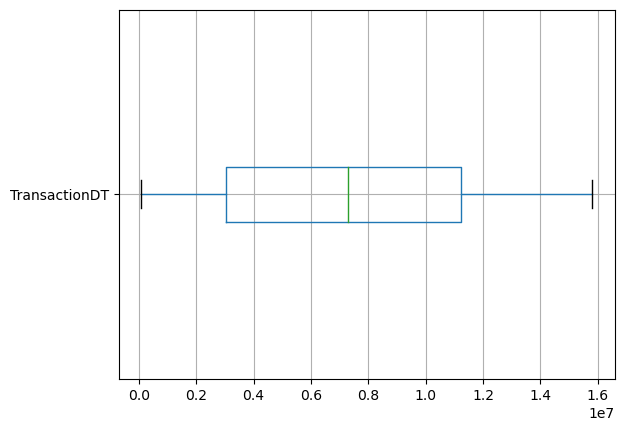

In [20]:
train[['TransactionDT']].boxplot(vert = False)
plt.show()

In [21]:
print("train: min = " + str(train.TransactionDT.min()) + ", train: max = " + str(train.TransactionDT.max()))
print("test: min = " + str(test.TransactionDT.min()) + ", test: max = " + str(test.TransactionDT.max()))

train: min = 86400, train: max = 15811131
test: min = 18403224, test: max = 34214345


In [22]:
time_span = (test.TransactionDT.max() - train.TransactionDT.min()) / 60 / 60 / 24
print("time span of the total datasets is: " + str(round(time_span)) + 'days')

time span of the total datasets is: 395days


2.2.2.2 ProductCD

In [23]:
print('type of ProductCD is ' + str(train["ProductCD"].dtypes))

type of ProductCD is object


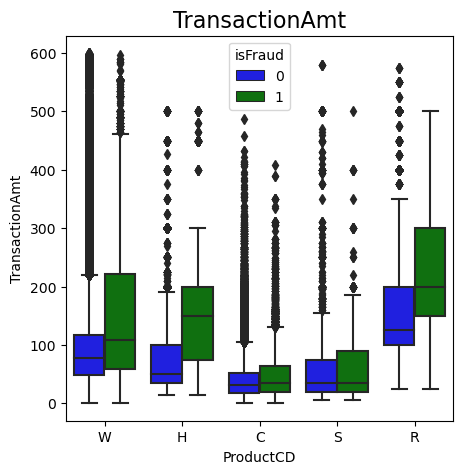

In [24]:
#visualize this feature in relation with the target, isFraud.
#Products in this dataset come under five broad categories: W, H, C, S, and R
fig, ax = plt.subplots(figsize=(5, 5))
plot = sns.boxplot(x="ProductCD", y="TransactionAmt", hue = "isFraud", data=train.query("TransactionAmt < 600"), palette=["blue", "green"], ax=ax).set_title('TransactionAmt', fontsize=16)
plt.show()

2.2.2.3 TransactionAmt

In [25]:
print('type of TransactionAmt is ' + str(train["TransactionAmt"].dtypes))

type of TransactionAmt is float16


In [27]:
#visualize this feature in relation with the target - isFraud.
sm = pd.DataFrame(
    [
        ['count',train['TransactionAmt'].count()],
        ['min',train.TransactionAmt.min()],
        ['max',train.TransactionAmt.max()],
        ['range',train.TransactionAmt.max() - train.TransactionDT.min()],
        ['mid-range',(train.TransactionAmt.max() - train.TransactionAmt.min())/2],
        ['mean',train.TransactionAmt.mean()],
        ['median',train.TransactionAmt.median()],
        ['std.dev',train.TransactionAmt.std()],
        ['variance',train.TransactionAmt.var()],
        ['mode',train.TransactionAmt.mode()],
        ['25%',train.TransactionAmt.quantile(0.25)],
        ['50%',train.TransactionAmt.quantile(0.50)],
        ['75%',train.TransactionAmt.quantile(0.75)],
        ['IQR',train.TransactionAmt.quantile(0.75)-train.TransactionAmt.quantile(0.25)]
    ],
    columns=['property','value']
)
sm

,property,value
0,count,590540
1,min,0.3
2,max,31936.0
3,range,-54464.0
4,mid-range,15968.0
5,mean,NaN
6,median,68.8
7,std.dev,NaN
8,variance,NaN
9,mode,"0 59.0 Name: TransactionAmt, dtype: float16"


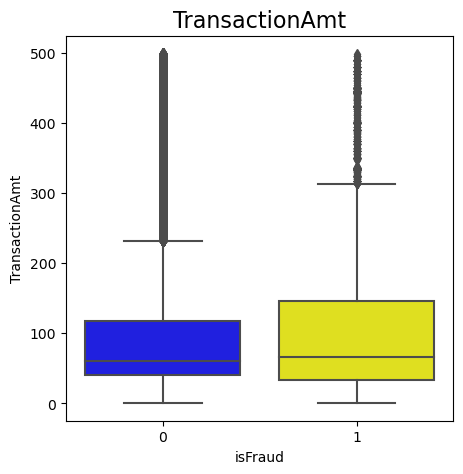

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))
plot = sns.boxplot(x="isFraud", y="TransactionAmt", data=train.query("TransactionAmt < 500"), palette=["blue", "yellow"], ax=ax).set_title('TransactionAmt', fontsize=16)
plt.show()

2.2.2.4 card brand (card4)

In [27]:
print('type of card4 is ' + str(train["card4"].dtypes))

type of card4 is object


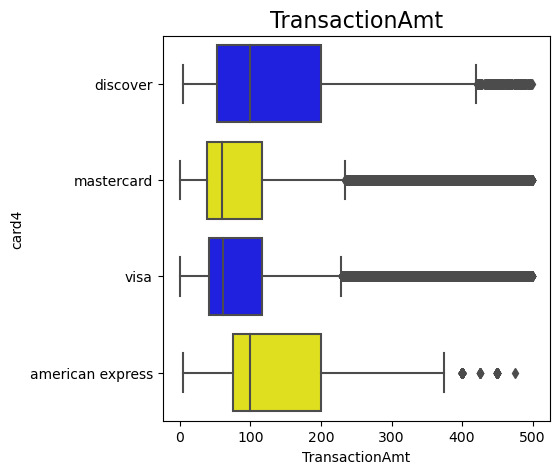

In [28]:
fig, ax = plt.subplots(figsize=(5, 5))
plot = sns.boxplot(x="TransactionAmt", y="card4", data=train.query("TransactionAmt < 500"), palette=["blue", "yellow"], ax=ax).set_title('TransactionAmt', fontsize=16)
plt.show()

2.2.2.5 Card type (card6)

In [29]:
print('type of card6 is ' + str(train["card6"].dtypes))

type of card6 is object


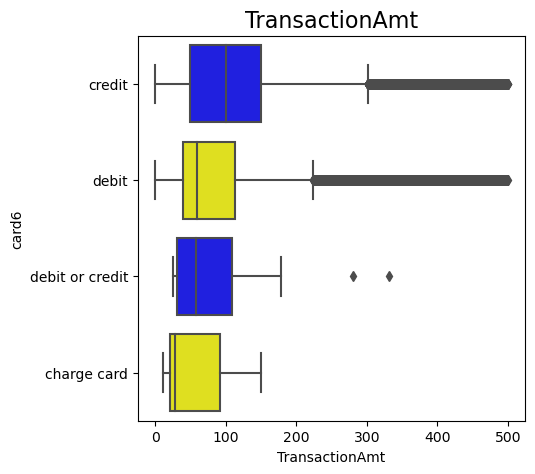

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))
plot = sns.boxplot(x="TransactionAmt", y="card6", data=train.query("TransactionAmt < 500"), palette=["blue", "yellow"], ax=ax).set_title('TransactionAmt', fontsize=16)
plt.show()

In [31]:
#finding coeffeicients between few numeric data columns
numeric_data = pd.DataFrame(train, columns = ['TransactionDT', 'TransactionAmt',
'V33','V12','C11','C2','V51', 'D4','D3','D15'])
numeric_data.corr(method = 'pearson')

,TransactionDT,TransactionAmt,V33,V12,C11,C2,V51,D4,D3,D15
TransactionDT,1.0e+00,1.2e-02,-1.3e-02,9.6e-02,-5.0e-02,-5.1e-02,-3.6e-02,6.0e-02,-7.2e-03,7.3e-02
TransactionAmt,1.2e-02,1.0e+00,-1.4e-01,8.4e-02,-1.7e-02,-1.8e-02,-1.5e-01,-5.0e-02,-2.2e-03,-5.5e-02
V33,-1.3e-02,-1.4e-01,1.0e+00,-3.7e-01,-2.4e-02,2.7e-02,9.4e-01,-2.0e-01,7.5e-03,-2.5e-01
V12,9.6e-02,8.4e-02,-3.7e-01,1.0e+00,-9.3e-03,-2.7e-02,-4.2e-01,-8.6e-02,-5.7e-02,-9.5e-02
C11,-5.0e-02,-1.7e-02,-2.4e-02,-9.3e-03,1.0e+00,9.9e-01,9.6e-02,5.4e-03,2.5e-04,2.3e-03
C2,-5.1e-02,-1.8e-02,2.7e-02,-2.7e-02,9.9e-01,1.0e+00,1.1e-01,-1.0e-03,7.4e-04,-4.8e-03
V51,-3.6e-02,-1.5e-01,9.4e-01,-4.2e-01,9.6e-02,1.1e-01,1.0e+00,-2.0e-01,1.9e-03,-2.6e-01
D4,6.0e-02,-5.0e-02,-2.0e-01,-8.6e-02,5.4e-03,-1.0e-03,-2.0e-01,1.0e+00,1.5e-01,7.5e-01
D3,-7.2e-03,-2.2e-03,7.5e-03,-5.7e-02,2.5e-04,7.4e-04,1.9e-03,1.5e-01,1.0e+00,1.4e-01
D15,7.3e-02,-5.5e-02,-2.5e-01,-9.5e-02,2.3e-03,-4.8e-03,-2.6e-01,7.5e-01,1.4e-01,1.0e+00


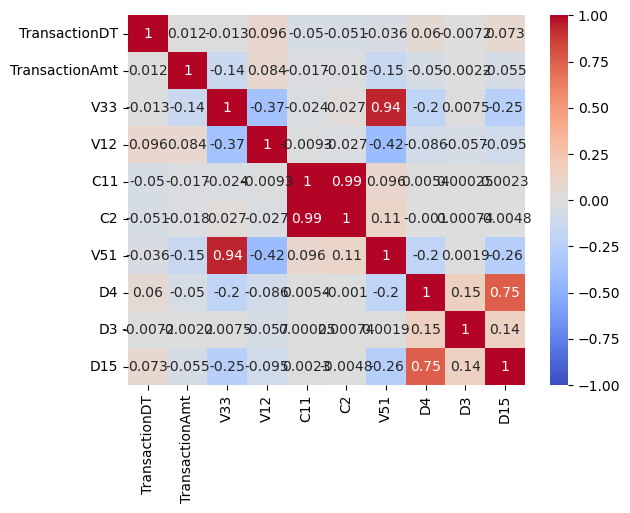

In [36]:
#A heat map is a data visualization technique that shows magnitude of a␣phenomenon as color in two dimensions.
sns.heatmap(numeric_data.corr(), vmin=-1, vmax=1, cmap = 'coolwarm', annot = True)
plt.show()

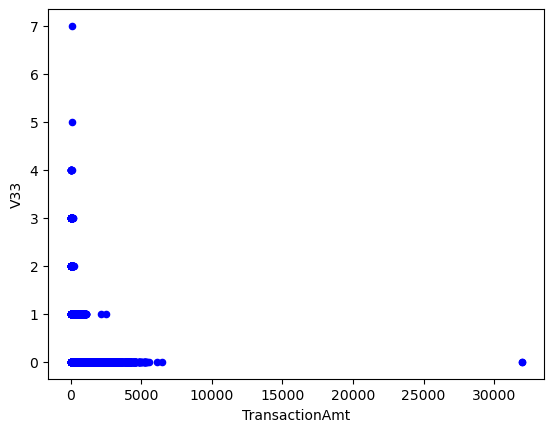

In [32]:
#pandas scatter plot between two variables
numeric_data.plot(x='TransactionAmt',y='V33',kind='scatter',color = 'Blue')
plt.show()

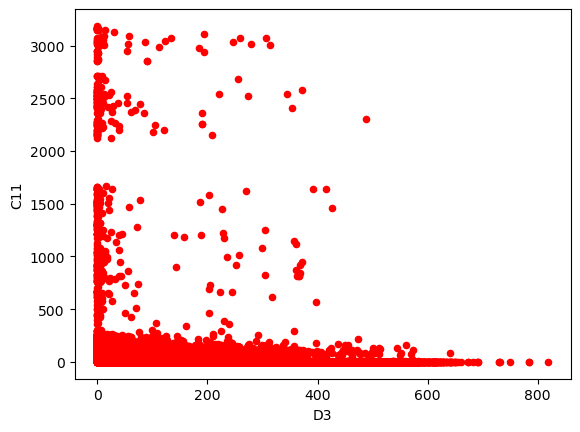

In [38]:
#pandas scatter plot between two variables
numeric_data.plot(x='D3',y='C11',kind='scatter',color = 'Red')
plt.show()

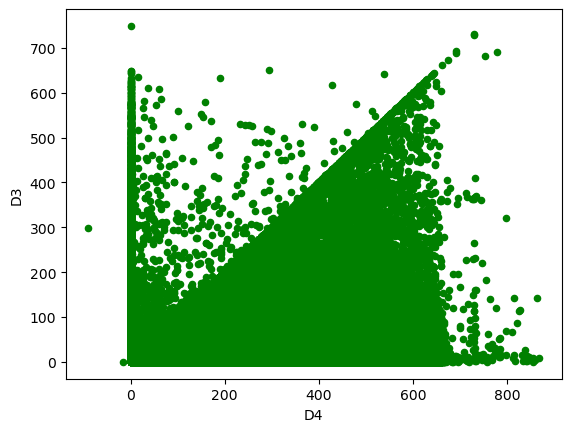

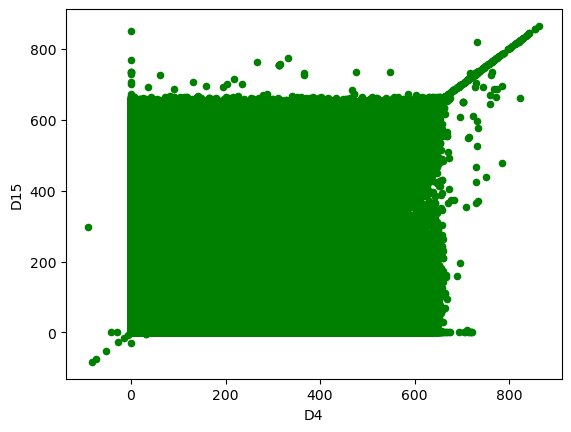

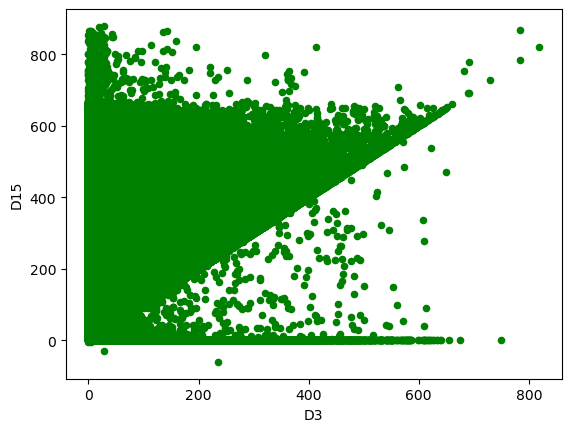

In [33]:
cols = ['D4','D3', 'D15']
for i in range(len(cols)):
    for j in range(i, len(cols)):
        if(i != j):
            numeric_data.plot(x=cols[i], y=cols[j], kind='scatter', color='green')
            plt.show()

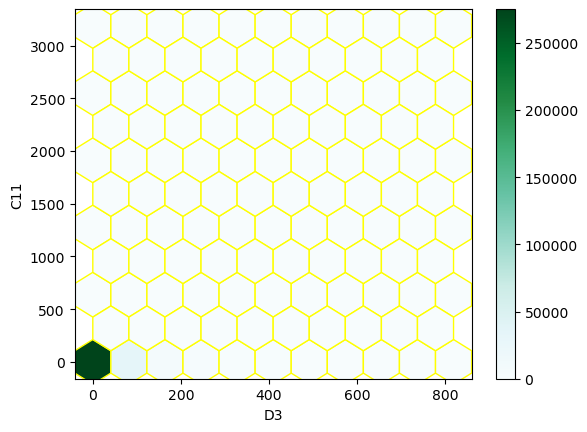

In [34]:
#pandas hexbin plot between two variables

numeric_data.plot(x='D3',y='C11',kind='hexbin',color = 'Yellow', gridsize =10)
plt.show()

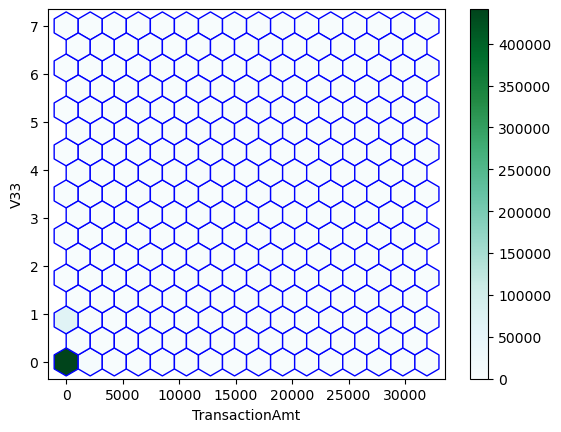

In [35]:
numeric_data.plot(x='TransactionAmt',y='V33',kind='hexbin',color = 'Blue', gridsize=15)
plt.show()

In [36]:
cols = ['D4','D3', 'D15']
for i in range(len(cols)):
    for j in range(i, len(cols)):
        if(i != j):
            numeric_data.plot(x=cols[i], y=cols[j], kind='hexbin', color='red', gridsize=10)

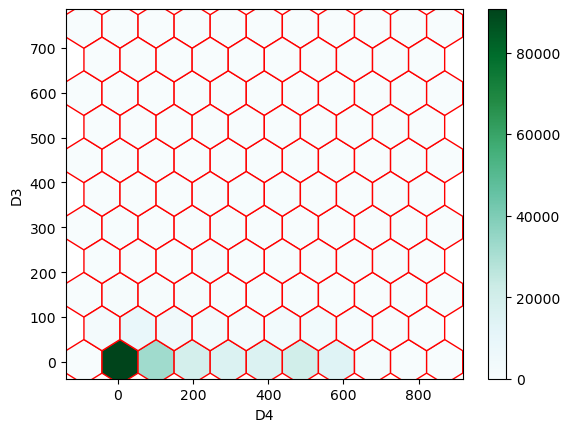

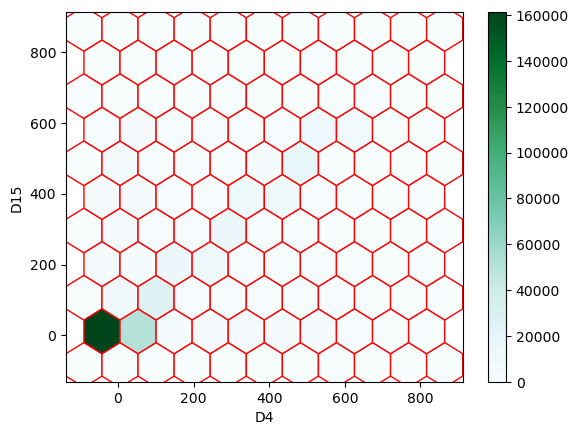

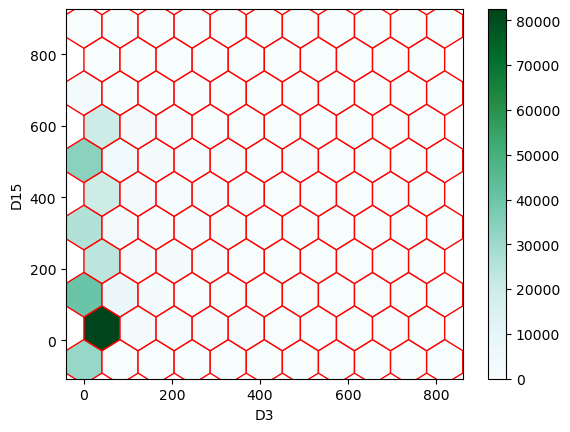

In [37]:
plt.show()

# Chi-square test

ProductCD and Card4

In [38]:
pd.DataFrame(train, columns = ['ProductCD', 'card4'])

,ProductCD,card4
0,W,discover
1,W,mastercard
2,W,visa
3,W,mastercard
4,H,mastercard
...,...,...
590535,W,visa
590536,W,mastercard
590537,W,mastercard
590538,W,mastercard


In [39]:
table = pd.crosstab(train['ProductCD'], train['card4'])
table

card4,american express,discover,mastercard,visa
ProductCD,,,,
C,2,0,27418,40904
H,1566,603,7938,22907
R,6138,1089,7432,23039
S,622,580,4042,6384
W,0,4379,142387,291533


In [40]:
observed_values = table.values
observed_values

array([[     2,      0,  27418,  40904],
       [  1566,    603,   7938,  22907],
       [  6138,   1089,   7432,  23039],
       [   622,    580,   4042,   6384],
       [     0,   4379, 142387, 291533]], dtype=int64)

In [42]:
# the significant value that will be used is 0.05
sig_value = 0.05

In [43]:
import scipy.stats as sp
from scipy.stats import chi2_contingency

#chi2 test stat, p-value, degrees of freedom expected frequencies
chi2_stat, p, dof, expected_freq = sp.chi2_contingency(table)
print('chi2 test stat =', round(chi2_stat, 4))
print('degrees of freedom =', dof)

chi2 test stat = 78171.3003
degrees of freedom = 12


In [44]:
from scipy.stats import chi2

crit_value = chi2.ppf(1 - sig_value, dof)
print("critical value =", round(crit_value, 4))
print()

if (chi2_stat >= crit_value):
    print("Because the chi2 test statisic is at least as large as the critical value,",
          "we reject the null hypothesis.")
    print("ProductCD and card4 are dependent features")
else:
    print("Because the chi2 test statisic is less than as the critical value,",
          "we do not reject the null hypothesis.")
    print("ProductCD and card4 are independent features")

critical value = 21.0261

Because the chi2 test statisic is at least as large as the critical value, we reject the null hypothesis.
ProductCD and card4 are dependent features
